In [1]:
%pylab inline
from scipy.optimize import minimize
from scipy.io import loadmat

Populating the interactive namespace from numpy and matplotlib


## Load Data

In [2]:
data = loadmat('ex5data1.mat')
X = np.ascontiguousarray(data['X']) # (12,1)
y = np.ascontiguousarray(data['y']) # (12,1)
Xval = np.ascontiguousarray(data['Xval']) # (21,1)
yval = np.ascontiguousarray(data['yval']) # (21,1)
Xtest = np.ascontiguousarray(data['Xtest']) # (21,1)
ytest = np.ascontiguousarray(data['ytest']) # (21,1)

## Plot Data

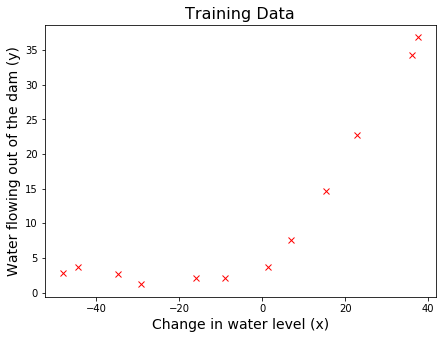

In [3]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X,y,'rx')
ax.set_xlabel('Change in water level (x)',fontsize=14)
ax.set_ylabel('Water flowing out of the dam (y)',fontsize=14)
ax.set_title('Training Data',fontsize=16);

## Insert Bias Feature

In [4]:
def insert_bias_feature(X):
    if np.ndim(X) == 1:
        X = np.reshape(X, (-1,1))
        
    return np.insert(X,0,1,axis=1)

## Initialize Theta

In [5]:
def initialize_theta(shape, order='C'):
    return np.zeros(shape)

## Cost Function

In [6]:
def regularized_linear_loss(theta,X,y,lamb=0):
    if np.ndim(theta) == 1:
        theta = np.reshape(theta,(-1,1))
    if np.ndim(y) == 1:
        y = np.reshape(y, (-1,1))
        
    X_biased = insert_bias_feature(X)
    z = X_biased @ theta
    J = np.sum(np.square(z - y)) / (2*len(y))
    reg = (lamb/(2*len(y))) * np.sum(np.square(theta[1:]))
    return np.sum(J + reg)

In [7]:
print(f'The cost is {regularized_linear_loss([1,1],X,y,lamb=1)}')

The cost is 303.9931922202643


## Regularized Linear Regression Gradient

In [8]:
def regularized_linear_gradient(theta,X,y,lamb=0):
    if np.ndim(theta) == 1:
        theta = np.reshape(theta,(-1,1))
    if np.ndim(y) == 1:
        y = np.reshape(y, (-1,1))
        
    X_biased = insert_bias_feature(X)
    z = X_biased @ theta
    D = (1/len(y)) * X_biased.T @ (z-y)
    D[1:] += (lamb/len(y)) * theta[1:]
    return D.squeeze()

In [9]:
print(f'The gradient is {regularized_linear_gradient([1,1],X,y,lamb=1)}')

The gradient is [-15.30301567 598.25074417]


## Fitting Linear Regression

In [10]:
def train_linear_regression(X,y,lamb):
    m, n = X.shape
    initial_theta = initialize_theta((n+1,1))
    result = minimize(fun=regularized_linear_loss,x0=initial_theta,args=(X,y,lamb),method='tnc',jac=regularized_linear_gradient,options={'maxiter': 400})
    theta = result.x
    return theta

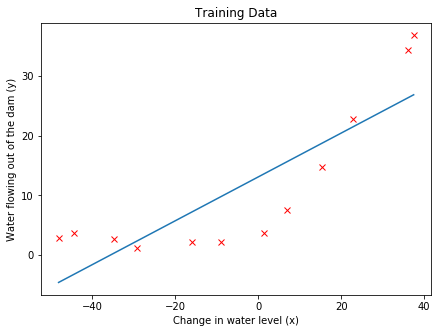

In [11]:
def plot_linear_regression(X,y,lamb):
    theta = train_linear_regression(X,y,lamb)
    
    # fit-curve coordinates
    X_fit = np.arange(X.min(),X.max(),0.05).reshape((-1,1))
    X_fit_biased = insert_bias_feature(X_fit)
    y_fit = X_fit_biased @ theta
    
    # plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(X,y,'rx')
    ax.plot(X_fit, y_fit)
    ax.set_xlabel('Change in water level (x)')
    ax.set_ylabel('Water flowing out of the dam (y)')
    ax.set_title('Training Data');
    
plot_linear_regression(X,y,0)

## Learning Curves

In [12]:
def learning_curves(X,y,Xval,yval,lamb):
    sample_size = list(range(1, len(y)+1))
    error_train = np.zeros(len(y))
    error_val = np.zeros(len(y))
    
    for i,n in enumerate(sample_size):
        theta = train_linear_regression(X[:n],y[:n],lamb)
        error_train[i] = regularized_linear_loss(theta,X[:n],y[:n],lamb=0)
        error_val[i] = regularized_linear_loss(theta,Xval,yval,lamb=0)
        
    return sample_size, error_train, error_val

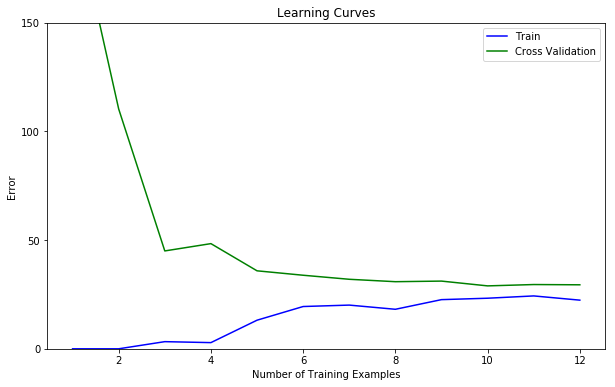

In [13]:
def plot_learning_curves(X,y,Xval,yval,lamb):
    sample_size, error_train, error_val = learning_curves(X,y,Xval,yval,lamb)

    #plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(sample_size,error_train,'b-',label='Train')
    ax.plot(sample_size,error_val,'g-',label='Cross Validation')
    ax.set_xlabel('Number of Training Examples')
    ax.set_ylabel('Error')
    ax.set_ylim(0,150)
    ax.set_yticks(range(0,151,50))
    ax.legend()
    ax.set_title('Learning Curves')

plot_learning_curves(X,y,Xval,yval,0)

> You can observe that both the train error and cross validation
error are high when the number of training examples is increased.
>This reflects a high bias problem (underfitting) in the model.

## Polynomial Regression

In [14]:
def poly_features(X,n):
    return X.dot(np.ones((1,n))).cumprod(axis=1)

In [15]:
def normalize_features(X, mu=None, sigma=None):
    mu = X.mean(axis=0) if mu is None else mu
    sigma = X.std(axis=0) if sigma is None else sigma
    return (X - mu) / sigma, mu, sigma

## Learning Degree

In [16]:
def degree_curves(X,y,Xval,yval,maxdeg=10):
    degree_values = np.arange(1,maxdeg)
    error_train = np.zeros(len(degree_values))
    error_val = np.zeros(len(degree_values))
    
    for i,degree in enumerate(degree_values):
        X_poly, mu, sigma = normalize_features(poly_features(X,degree))
        Xval_poly = normalize_features(poly_features(Xval,degree), mu=mu, sigma=sigma)[0]
        
        theta = train_linear_regression(X_poly,y,lamb=0)
        error_train[i] = regularized_linear_loss(theta,X_poly,y,lamb=0)
        error_val[i] = regularized_linear_loss(theta,Xval_poly,yval,lamb=0)
         
    return degree_values, error_train, error_val

In [17]:
def plot_degree_curves(X,y,Xval,yval,maxdeg=10):
    degree_values, error_train, error_val = degree_curves(X,y,Xval,yval,maxdeg)

    #plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(degree_values,error_train,'b-',label='Train')
    ax.plot(degree_values,error_val,'g-',label='Cross Validation')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('Error')
    ax.set_xticks(degree_values)
    ax.legend()
    ax.set_title('Validation Curve')

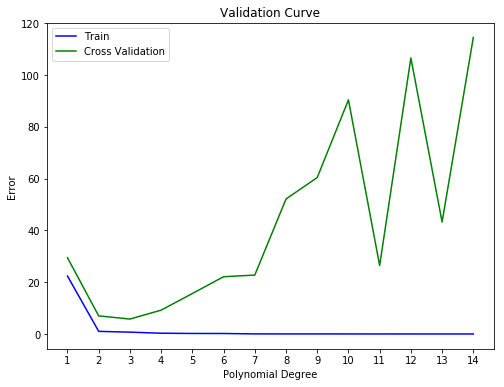

In [18]:
plot_degree_curves(X,y,Xval,yval,maxdeg=15)

## Learning Polynomial Regression

In [19]:
def plot_polynomial_linear_regression(X,y,degree,lamb):
    X_poly, mu, sigma = normalize_features(poly_features(X,degree))
    
    # fit model
    theta = train_linear_regression(X_poly,y,lamb)
    
    # fit-curve coordinates
    #X_fit = np.linspace(X.min()-5,X.max()+5,100)
    X_fit = np.linspace(-60, 60)
    X_fit_poly = normalize_features(poly_features(X_fit.reshape((-1,1)),degree), mu=mu, sigma=sigma)[0]
    X_fit_poly_biased = insert_bias_feature(X_fit_poly)
    y_fit = X_fit_poly_biased @ theta
    
    # plot
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    
    ax[0].plot(X,y,'rx')
    ax[0].plot(X_fit, y_fit,'--')
    ax[0].set_xlabel('Change in water level (x)')
    ax[0].set_ylabel('Water flowing out of the dam (y)')
    ax[0].set_xlim(-80,80)
    #ax[0].set_ylim(0,180)
    ax[0].set_title('Training Data');
    
    Xval_poly = normalize_features(poly_features(Xval,degree), mu=mu, sigma=sigma)[0]
    sample_size, error_train, error_val = learning_curves(X_poly,y,Xval_poly,yval,lamb)
    
    ax[1].plot(sample_size,error_train,'b-',label='Train')
    ax[1].plot(sample_size,error_val,'g-',label='Cross Validation')
    ax[1].set_xlabel('Number of Training Examples')
    ax[1].set_ylabel('Error')
    ax[1].legend()
    ax[1].set_title('Learning Curves')

## $\lambda = 0$

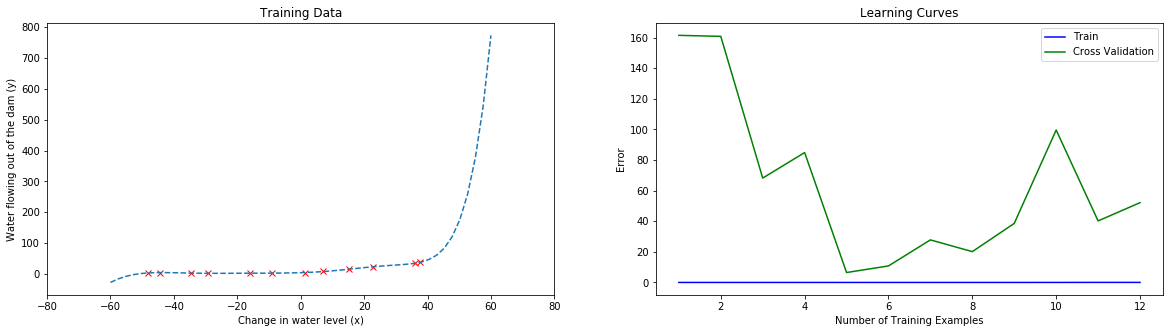

In [35]:
plot_polynomial_linear_regression(X,y,degree=8,lamb=0)

## $\lambda = 1$

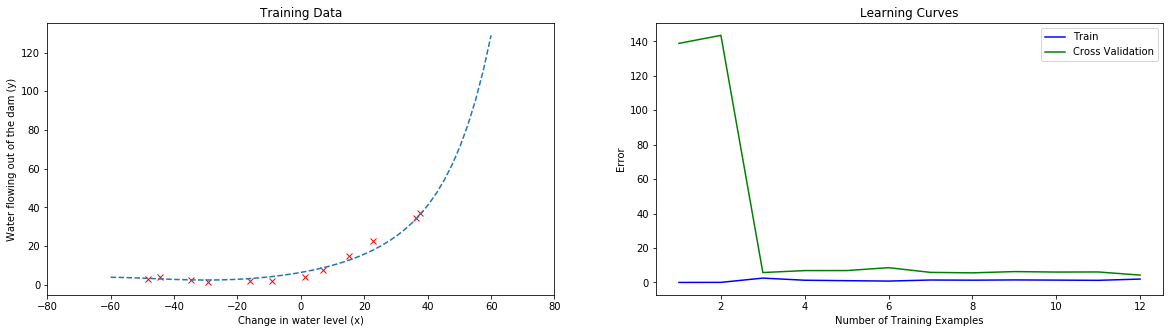

In [21]:
 plot_polynomial_linear_regression(X,y,degree=8,lamb=1)

## $\lambda = 100$

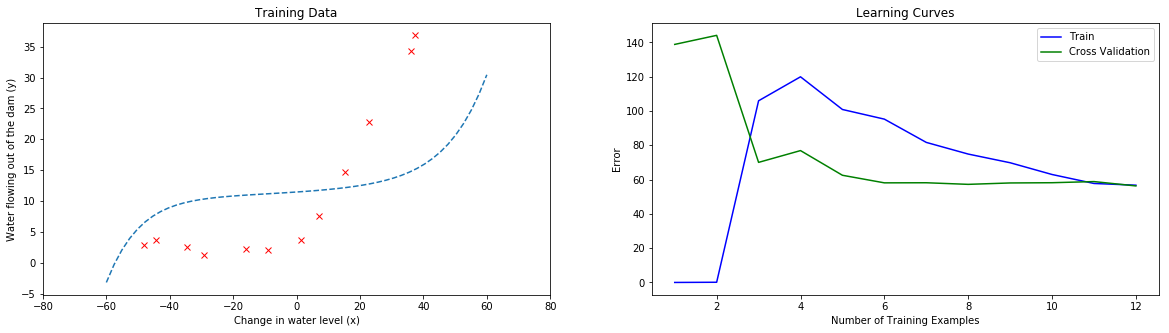

In [22]:
plot_polynomial_linear_regression(X,y,degree=8,lamb=100)

## Selecting λ using a Cross Validation Set

In [23]:
def lambda_curves(X,y,Xval,yval):
    lambda_values = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = np.zeros(len(lambda_values))
    error_val = np.zeros(len(lambda_values))
    
    for i,lamb in enumerate(lambda_values):
        theta = train_linear_regression(X,y,lamb)
        error_train[i] = regularized_linear_loss(theta,X,y,lamb=0)
        error_val[i] = regularized_linear_loss(theta,Xval,yval,lamb=0)
        
    return lambda_values, error_train, error_val

In [24]:
def plot_lambda_curves(X,y,Xval,yval,degree):
    X_poly, mu, sigma = normalize_features(poly_features(X,degree))
    Xval_poly = normalize_features(poly_features(Xval,degree), mu=mu, sigma=sigma)[0]
    lambda_values, error_train, error_val = lambda_curves(X_poly,y,Xval_poly,yval)

    #plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(lambda_values,error_train,'b-',label='Train')
    ax.plot(lambda_values,error_val,'g-',label='Cross Validation')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Error')
    ax.set_xlim(0,10)
    ax.set_ylim(0,20)
    ax.set_xticks(range(0,11))
    ax.set_yticks(range(0,21,2))
    ax.legend()
    ax.set_title('Validation Curve')

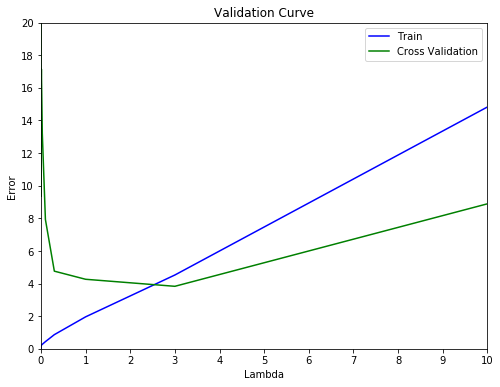

In [25]:
plot_lambda_curves(X,y,Xval,yval,degree=8)

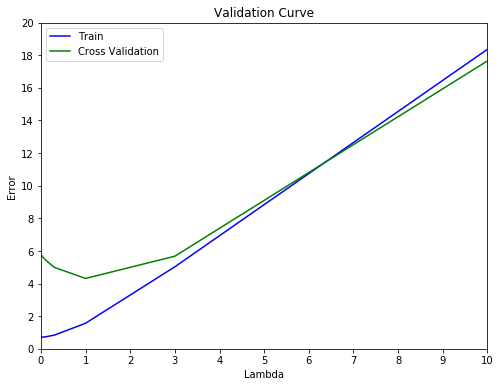

In [26]:
plot_lambda_curves(X,y,Xval,yval,degree=3)

## Test Error

In [27]:
def compute_test_error(X,y,Xtest,ytest,degree,lamb):
    X_poly, mu, sigma = normalize_features(poly_features(X,degree))
    Xval_poly = normalize_features(poly_features(Xval,degree), mu, sigma)[0]
    Xtest_poly = normalize_features(poly_features(Xtest,degree), mu, sigma)[0]
    
    theta = train_linear_regression(X_poly,y,lamb)
    print(f'The training error is {regularized_linear_loss(theta,X_poly,y,lamb=0)}')
    print(f'The validation error is {regularized_linear_loss(theta,Xval_poly,yval,lamb=0)}')
    print(f'The test error is {regularized_linear_loss(theta,Xtest_poly,ytest,lamb=0)}')

In [28]:
compute_test_error(X,y,Xtest,ytest,degree=8,lamb=3)

The training error is 4.525122504242227
The validation error is 3.8321771233902275
The test error is 3.5720485398329758


In [29]:
compute_test_error(X,y,Xtest,ytest,degree=3,lamb=1)

The training error is 1.5669200378733024
The validation error is 4.314049758380757
The test error is 4.9337618033521276


## Learning Random Curves

In [30]:
def learning_random_curves(X,y,Xval,yval,degree=1,lamb=0):
    sample_size = list(range(2, len(y)+1))
    error_train = np.zeros(len(sample_size))
    error_val = np.zeros(len(sample_size))
    
    for i,n in enumerate(sample_size):
        error_train_rand = np.zeros(50)
        error_val_rand = np.zeros(50)
        for j in range(50):
            rand_idx = np.random.choice(len(y),n,replace=False)
            X_rand, mu, sigma = normalize_features(poly_features(X[rand_idx],degree))
            Xval_rand = normalize_features(poly_features(Xval[rand_idx],degree), mu=mu, sigma=sigma)[0]
            y_rand = y[rand_idx]
            yval_rand = yval[rand_idx]
            
            theta = train_linear_regression(X_rand,y_rand,lamb)
            error_train_rand[j] = regularized_linear_loss(theta,X_rand,y_rand,lamb=0)
            error_val_rand[j] = regularized_linear_loss(theta,Xval_rand,yval_rand,lamb=0)
        error_train[i] = np.mean(error_train_rand,axis=0)
        error_val[i] = np.mean(error_val_rand,axis=0)
        
    return sample_size, error_train, error_val

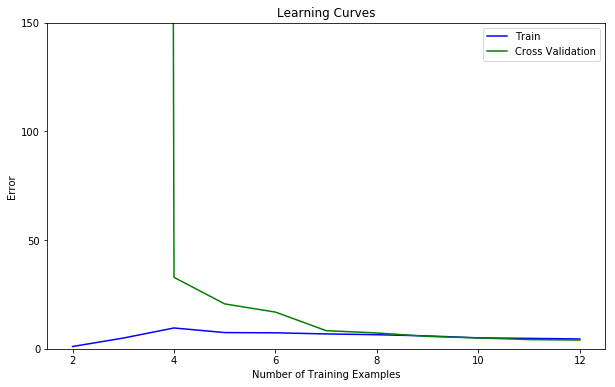

In [31]:
def plot_learning_random_curves(X,y,Xval,yval,degree=1,lamb=0):
    sample_size, error_train, error_val = learning_random_curves(X,y,Xval,yval,degree,lamb)

    #plot
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(sample_size,error_train,'b-',label='Train')
    ax.plot(sample_size,error_val,'g-',label='Cross Validation')
    ax.set_xlabel('Number of Training Examples')
    ax.set_ylabel('Error')
    ax.set_ylim(0,150)
    ax.set_yticks(range(0,151,50))
    ax.legend()
    ax.set_title('Learning Curves')

plot_learning_random_curves(X,y,Xval,yval,degree=8,lamb=3)